# Kaggle Learn: Intermediate Machine Learning

In this notebook, we continue the study of Machine Learning. We now look at more complex concepts and methods.

Before we get started, here are a couple things that could be added onto the previous notebook:

- In order to specify the amount split when splitting training data, we use the `train_size` and `test_size` arguments.

- We can further improve the `RandomForestRegressor` submission by utilising other parameters, such as `criterion`, `min_samples_split` and `max_depth`.

## Table Of Contents

* **0.** [Dependancies and Settings](#0-Dependancies-and-Settings)  
* **1.** [Useful Links](#1-Useful-Links)  
* **2.** [Missing Values](#2-Missing-Values)  
  * **2.1.** [Dropping Columns](#2.1-Dropping-Columns)  
  * **2.2.** [Imputation](#2.2-Imputation)  
  * **2.3.** [Extension to Imputation](#2.3-Extension-to-Imputation)  
  * **2.4.** [What we have so far](#2.4-What-we-have-so-far)  
* **3.** [Categorical Variables](#3-Categorical-Variables)  
  * **3.1.** [Drop Categorical Variables](#3.1-Drop-Categorical-Variables)  
  * **3.2.** [Ordinal Encoding](#3.2-Ordinal-Encoding)  
  * **3.3.** [One-Hot Encoding](#3.3-One-Hot-Encoding)  
* **4.** [Pipelines](#4-Pipelines)  
  * **4.1.** [Defining preprocessing steps](#4.1-Defining-preprocessing-steps)  
  * **4.2.** [Define the model](#4.2-Define-the-model)  
  * **4.3.** [Create and evaluate the pipeline](#4.3-Create-and-evaluate-the-pipeline)  
* **5.** [Cross-Validation](#5-Cross-Validation)  
  * **5.1.** [Parameter optimization](#5.1-Parameter-optimization)  
* **6.** [XGBoost](#6-XGBoost)  
  * **6.1.** [Basic Implementation](#6.1-Basic-Implementation)  
  * **6.2.** [Parameter tuning](#6.2-Parameter-tuning)  
* **7.** [Data Leakage](#7-Data-Leakage)  
  * **7.1.** [Target leakage](#7.1-Target-leakage)  
  * **7.2.** [Train-test contamination](#7.2-Train-test-contamination)  
  * **7.3.** [Example scenarios](#7.3-Example-scenarios)  

## 0 Dependancies and Settings

Installation:

In [1]:
# Installing or upgrading
# Note: might have to restart kernel

# Uncomment:
# import sys

# Installing:
# !{sys.executable} -m pip install scikit-learn
# Upgrading:
# !{sys.executable} -m pip install --upgrade scipy==1.9.0 --user

Imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [3]:
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('scikit-learn version:', sklearn.__version__)

pandas version: 1.5.2
numpy version: 1.23.0
scikit-learn version: 1.2.0


Set the plotting style:

In [4]:
try:
    scientific_style = [
        '../../Random/PythonTutorialsForDataScience/data/science.mplstyle', 
        '../../Random/PythonTutorialsForDataScience/data/notebook.mplstyle', 
        '../../Random/PythonTutorialsForDataScience/data/grid.mplstyle'
    ]

    plt.style.use(scientific_style)
    
    print('Using Scientific Style.')
except:
    print('Missing Scientific Style, continuing with default.')

Using Scientific Style.


Define the filepath where most of the data resides:

In [5]:
path = r'C:\Users\seani\Documents\JupyterNotebooks\Kaggle\KaggleLearn\Assets'

Function used to get names of files in a directory:

In [6]:
import os

def get_files(path):
    '''
    Inputs: a path string
    Returns: a list of names of files in a directory
    '''
    
    files = []
    # search through each item in the directory
    for file in os.listdir(path):
        # check it is a file
        if os.path.isfile(os.path.join(path, file)):
            files.append(file)
    
    return files

The seed used throughout for reproducable randomness:

In [7]:
seed = 1

## 1 Useful Links

- scikit-learn docs: https://scikit-learn.org/stable/modules/classes.html
- Melbourne Housing snapshot: https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot
- Iowa Housing dataset: https://www.kaggle.com/datasets/dansbecker/home-data-for-ml-course

## 2 Missing Values

There are many ways data can end up with missing values. For example:

- A 2 bedroom house won't include a value for the size of a third bedroom.
- A survey respondent may choose not to share his income.

Most ML libraries (including scikit-learn) give an error if you try to build a model using data with missing values. In the previous notebook we conveniently chose columns (features) that had no missing values, avoiding the problem altogether.

There are three main approaches to fix missing data that we will discuss. First, let's investigate the data we will be working with. The training and test data are created below, with the training data displayed:

In [8]:
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv(
    'Assets/iowa_data.csv', 
    index_col='Id'
)

# Remove rows with missing target
X_full.dropna(
    axis=0, 
    subset=['SalePrice'], 
    inplace=True
)
# separate target from predictors
y = X_full.SalePrice
X_full.drop(
    ['SalePrice'], 
    axis=1, 
    inplace=True
)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])

# Split validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    train_size=0.8,
    test_size=0.2,
    random_state=0,
)

# final testing data
X_test_full = pd.read_csv(
    'Assets/housingprices_test.csv', 
    index_col='Id'
)

X_test = X_test_full.select_dtypes(exclude=['object'])

X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,774,0,108,0,0,260,0,0,7,2007
871,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,308,0,0,0,0,0,0,0,8,2009
93,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,432,0,0,44,0,0,0,0,8,2009
818,20,NaN,13265,8,5,2002,2002,148.0,1218,0,...,857,150,59,0,0,0,0,0,7,2008
303,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,843,468,81,0,0,0,0,0,1,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,60,82.0,9430,8,5,1999,1999,673.0,1163,0,...,856,0,128,0,0,180,0,0,7,2009
836,20,60.0,9600,4,7,1950,1995,0.0,442,0,...,436,290,0,0,0,0,0,0,2,2010
1217,90,68.0,8930,6,5,1978,1978,0.0,0,0,...,539,0,0,0,0,0,0,0,4,2010


We can already see a few missing values. Let's investigate this data further:

In [9]:
# Shape of training data (num_rows, num_columns)?
print(f'> Shape of training data (num_rows, num_columns)?\n{X_train.shape}')

# Number of missing values in each column of training data?
missing_val_count_by_column = (X_train.isnull().sum())
print(f'> Number of missing values in each column of training data?\n{missing_val_count_by_column[missing_val_count_by_column > 0]}')

# How many rows are in the training data?
num_rows = X_train.shape[0]
print(f'> How many rows are in the training data?\n{num_rows}')

# How many columns in the training data have missing values?
num_cols_with_missing = missing_val_count_by_column[missing_val_count_by_column > 0].count()
print(f'> How many columns in the training data have missing values?\n{num_cols_with_missing}')

# How many missing entries are contained in all of the training data?
tot_missing = missing_val_count_by_column[missing_val_count_by_column > 0].sum()
print(f'> How many missing entries are contained in all of the training data?\n{tot_missing}')

> Shape of training data (num_rows, num_columns)?
(1168, 36)
> Number of missing values in each column of training data?
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64
> How many rows are in the training data?
1168
> How many columns in the training data have missing values?
3
> How many missing entries are contained in all of the training data?
276


To compare different approaches to dealing with missing values, we create a function to find the mean absolute error ($\mathrm{MAE}$) from a random forest model:

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# get the mae of a random forest model
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

*Note: essentially, our goal is to find the optimal way to deal with missing values in our data such that we can get the most value from our data.*

### 2.1 Dropping Columns

The simplest option is to drop columns with missing values:

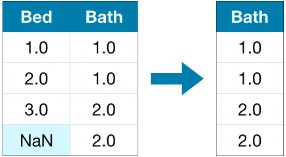

*Figure 1: The `Bed` column contains a missing value, so we drop it in the preprocessing step.*

Unless most values in the dropped columns are missing, the model loses access to a lot of (potentially useful!) information with this approach. As an extreme example, consider a dataset with 10,000 rows, where one important column is missing a single entry. This approach would drop the column entirely!

Let's preprocess the data in `X_train` and `X_valid` to remove columns with missing values. We set the preprocessed DataFrames to `reduced_X_train` and `reduced_X_valid`, respectively. We can then see how this performs using the above function:

In [11]:
# get names of columns with missing values
# .isnull() puts True where a value is null, and False where it is not
# .any() checks if any values are True, and returns True if so
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print(f'MAE (Drop columns with missing values): {score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid)}')

MAE (Drop columns with missing values): 17837.82570776256


### 2.2 Imputation

**Imputation** fills in the missing values with some number. For instance, we can fill in the mean value along each column:

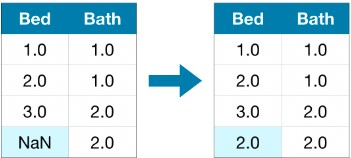

*Figure 2: The missing value in the `Bed` column is replaced (imputed) with the mean of the other values in that column.*

The imputed value won't be exactly right in most cases, but it usually leads to more accurate models than you would get from dropping the column entirely.

Let's preprocess the data in `X_train` and `X_valid` to perform imputation on the missing values. We set the preprocessed DataFrames to `imputed_X_train` and `imputed_X_valid`, respectively. We can then see how this performs using the scoring function:

In [12]:
from sklearn.impute import SimpleImputer

# imputation
imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))  # fit nan values using mean, then transform by applying this fit
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))  # transform removes the nan values, as it doesnt make sense to estimate validation data

# imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print(f'MAE (Imputation): {score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid)}')

MAE (Imputation): 18062.894611872147


Since there are relatively few missing entries in the data (the column with the greatest percentage of missing values is missing less than $20\%$ of its entries), we can expect that dropping columns is unlikely to yield good results. This is because we'd be throwing away a lot of valuable data, and so imputation will likely perform better.

However, we see that dropping columns performs slightly better! While this can probably partially be attributed to noise in the dataset, another potential explanation is that the imputation method is not a great match to this dataset. That is, maybe instead of filling in the mean value, it makes more sense to set every missing value to a value of 0, to fill in the most frequently encountered value, or to use some other method. 

For instance, consider the `GarageYrBlt` column (which indicates the year that the garage was built). It's likely that in some cases, a missing value could indicate a house that does not have a garage. Does it make sense to fill in the mean value in this case? Some other methods to consider:

- Fill in median value
- Fill in minimum value

It's not quite clear what's best in this case, but perhaps we can rule out some options immediately - for instance, setting missing values in this column to 0 is likely to yield horrible results!

### 2.3 Extension to Imputation

Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, your model would make better predictions by considering which values were originally missing:

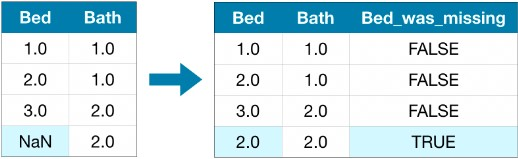

*Figure 3: The missing value in the `Bed` column is replaced (imputed) with the mean of the other values in that column. The column `Bed_was_missing` is added, containing `False` for all rows that were not imputed, but `True` for the row that was.*

In this approach, we impute the missing values, as before. And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries.

In some cases, this will meaningfully improve results. In other cases, it doesn't help at all.

Let's preprocess the data in `X_train` and `X_valid` to perform imputation with this extension on the missing values. We set the preprocessed DataFrames to `imputed_X_train_plus` and `imputed_X_valid_plus`, respectively. We can then see how this performs using the scoring function:

In [13]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# get names of columns with missing values
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print(f'MAE (Imputation with Extension): {score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid)}')

MAE (Imputation with Extension): 18148.417180365297


This performs slightly worse than the original imputation method.

*Note: It is more common for imputing missing values (in Approach 2 and Approach 3) to yield better results, relative to when we simply dropped columns with missing values (in Approach 1).*

### 2.4 What we have so far

Using what we have so far, we can try to improve on our previous score. We will perform imputation on the training and testing data (taking care to make sure they have the same number of columns). We then use the same method to create a file for submission:

In [14]:
# TRAINING AND VALIDATING

# imputation
imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))  # fit it by mean, then transform by applying
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))  # transform removes the nan values, as it doesnt make sense to estimate validation data

# imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

# Define and fit model
model = RandomForestRegressor(
    n_estimators=70,
    criterion='absolute_error',
    random_state=0,
)
model.fit(imputed_X_train, y_train)

# Get validation predictions and MAE
preds_valid = model.predict(imputed_X_valid)
print(f'MAE: {mean_absolute_error(y_valid, preds_valid)}')

# TESTING

# imputation
imputer = SimpleImputer(strategy='median') # Your code here
imputed_X_test = pd.DataFrame(imputer.fit_transform(X_test))  # fit it by mean, then transform by applying

# imputation removed column names; put them back
imputed_X_test.columns = X_test.columns

# get test predictions
preds_test = model.predict(imputed_X_test)

# SUBMISSION

# create dataframe of the predicted values
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})

# send to csv (uncomment below line)
#output.to_csv('submission_IntermediateML.csv', index=False)

output

MAE: 17852.45044031311


,Id,SalePrice
0,1461,125641.657143
1,1462,153068.571429
2,1463,182598.428571
3,1464,176441.885714
4,1465,194890.342857
...,...,...
1454,2915,84528.571429
1455,2916,86105.714286
1456,2917,155898.000000
1457,2918,111456.428571


When submitted, this achieved a score of $17009.9748$. This is an improvement on the score obtained at the end of the previous notebook.

## 3 Categorical Variables

Categorical Variables describe data that can be fit into *distinct* categories. For example:

- We take a survey of the colour of cars that pass a particular street, the data collected fits into either "Red", "Blue", "Green", or "Other". This is **categorical data**.

- The number of cars that we survey is also noted, along with the number of passengers. These would be examples of **numerical data**, NOT categorical.

We will get an error if we try to plug these variables into most machine learning models in Python without preprocessing them first. In this section, we'll compare three approaches that we can use to prepare our categorical data.

As before, let's first investigate the data we will be working with. We mostly follow the same routine:

In [15]:
# Read the data
X = pd.read_csv('Assets/iowa_data.csv', index_col='Id') 
X_test = pd.read_csv('Assets/housingprices_test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    train_size=0.8, test_size=0.2,
    random_state=0,
)

X_train

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,RL,11694,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,108,0,0,260,0,0,7,2007,New,Partial
871,20,RL,6600,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,0,8,2009,WD,Normal
93,30,RL,13360,Pave,IR1,HLS,AllPub,Inside,Gtl,Crawfor,...,0,44,0,0,0,0,8,2009,WD,Normal
818,20,RL,13265,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,59,0,0,0,0,0,7,2008,WD,Normal
303,20,RL,13704,Pave,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,...,81,0,0,0,0,0,1,2006,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,60,RL,9430,Pave,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,...,128,0,0,180,0,0,7,2009,WD,Normal
836,20,RL,9600,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,...,0,0,0,0,0,0,2,2010,WD,Normal
1217,90,RM,8930,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,...,0,0,0,0,0,0,4,2010,WD,Normal


Notice all of the categorical data we have been ignoring! To score the dataset, we will use the `score_dataset(X_train, X_valid, y_train, y_valid)` function created in the previous section. For simplicity, we ignore columns with missing values. Let's get a list of all the categorical variables:

In [16]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


Now, let's compare the training and validation data. Specifically, we'll look at the `Condition2` column. The code cell below prints the unique entries in both the training and validation sets.

In [17]:
print("Unique values in 'Condition2' column in training data:", sorted(X_train['Condition2'].unique()))
print("\nUnique values in 'Condition2' column in validation data:", sorted(X_valid['Condition2'].unique()))

Unique values in 'Condition2' column in training data: ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe']

Unique values in 'Condition2' column in validation data: ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn', 'RRNn']


We can see from this that there are some entries in the validation data that are not in the training data (this happens because we split the full dataset, and some entries just so happen to end up in one split and not the other). It is common when we deal with categorical variables to create an encoder that takes the entries and converts them to some integer that has been assigned to that value. In the case that the validation data contains values that don't also appear in the training data, the encoder will throw an error, because these values won't have an integer assigned to them.

There are many approaches to fixing this issue. For instance, you can write a custom encoder to deal with new categories. The simplest approach, however, is to drop the problematic categorical columns.

Before looking at the three approaches, there's one additional topic we need to cover. We will investigate the **cardinality** of a categorical variable. See the below output:

In [18]:
# Get number of unique entries in each column with categorical data
# nunique() counts the number of unique entries, whereas the map lets
# us check the number of columns for each column in object_cols
# we then zip with the object columns to display them side by side
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

The output above shows, for each column with categorical data, the number of unique values in the column. For instance, the 'Street' column in the training data has two unique values: 'Grvl' and 'Pave', corresponding to a gravel road and a paved road, respectively.

We refer to the number of unique entries of a categorical variable as the **cardinality** of that categorical variable. For instance, the 'Street' variable has cardinality 2.

In [19]:
# How many categorical variables in the training data have cardinality greater than 10?
# check number of unique entries then see if greater than 10, and make sure column is categorical (object)
high_cardinality_numcols = len(
    [col for col in X_train.columns if X_train[col].nunique() > 10 and X_train[col].dtype == 'object']
)
print(f'How many categorical variables in the training data have cardinality greater than 10?\n> {high_cardinality_numcols}')

How many categorical variables in the training data have cardinality greater than 10?
> 3


### 3.1 Drop Categorical Variables

The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information. We set the preprocessed DataFrames to `drop_X_train` and `drop_X_valid`, respectively.

In [20]:
# drop columns in training and validation data
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

drop_X_train = X_train[numerical_cols]
drop_X_valid = X_valid[numerical_cols]

drop_X_train

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,20,11694,9,5,2007,2007,48,0,1774,1822,...,774,0,108,0,0,260,0,0,7,2007
871,20,6600,5,5,1962,1962,0,0,894,894,...,308,0,0,0,0,0,0,0,8,2009
93,30,13360,5,7,1921,2006,713,0,163,876,...,432,0,0,44,0,0,0,0,8,2009
818,20,13265,8,5,2002,2002,1218,0,350,1568,...,857,150,59,0,0,0,0,0,7,2008
303,20,13704,7,5,2001,2002,0,0,1541,1541,...,843,468,81,0,0,0,0,0,1,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,60,9430,8,5,1999,1999,1163,0,89,1252,...,856,0,128,0,0,180,0,0,7,2009
836,20,9600,4,7,1950,1995,442,0,625,1067,...,436,290,0,0,0,0,0,0,2,2010
1217,90,8930,6,5,1978,1978,0,0,0,0,...,539,0,0,0,0,0,0,0,4,2010


This is essentially how we have dealt with categorical variables so far, we get a score as follows:

In [21]:
print(f'MAE (Drop categorical variables): {score_dataset(drop_X_train, drop_X_valid, y_train, y_valid)}')

MAE (Drop categorical variables): 17837.82570776256


### 3.2 Ordinal Encoding

**Ordinal encoding** assigns each unique value to a different integer. For example, we assign a particular integer to each of the unique entries in the `Breakfast` categorical variable:

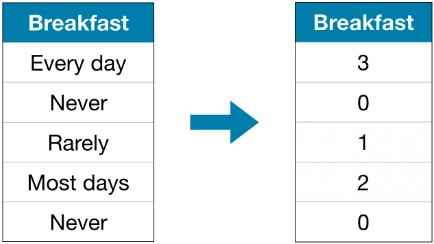

*Figure 4: Ordinal Encoding on the `Breakfast` categorical variable. This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).*

This assumption makes sense in this example, because there is a clear ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as **ordinal variables**. For tree-based models (like decision trees and random forests), you can expect ordinal encoding to work well with ordinal variables.

As mentioned before, we must make sure the validation data we use contains the same entries as encoded in the training data. As such, we can find which columns they share (`good_label_cols`) and do not share (`bad_label_cols`):

In [22]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
# make sure the set of categorical columns in the validation data is 
# a subset of categorical columns in the training data
good_label_cols = [col for col in object_cols 
                   if set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
# These are whichever columns are NOT the good ones
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Functional', 'Condition2', 'RoofMatl']


Let us now perform the Ordinal Encoding on the columns we have found to be suitable. We use the `OrdinalEncoder` function from `sklearn.preprocessing`. We will set the preprocessed DataFrames to `label_X_train` and `label_X_valid`, respectively:

In [23]:
from sklearn.preprocessing import OrdinalEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder
ordinal_encoder = OrdinalEncoder()
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(label_X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(label_X_valid[good_label_cols])

label_X_train

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,3.0,11694,1.0,3.0,3.0,0.0,4.0,0.0,16.0,...,108,0,0,260,0,0,7,2007,6.0,5.0
871,20,3.0,6600,1.0,3.0,3.0,0.0,4.0,0.0,12.0,...,0,0,0,0,0,0,8,2009,8.0,4.0
93,30,3.0,13360,1.0,0.0,1.0,0.0,4.0,0.0,6.0,...,0,44,0,0,0,0,8,2009,8.0,4.0
818,20,3.0,13265,1.0,0.0,3.0,0.0,1.0,0.0,11.0,...,59,0,0,0,0,0,7,2008,8.0,4.0
303,20,3.0,13704,1.0,0.0,3.0,0.0,0.0,0.0,5.0,...,81,0,0,0,0,0,1,2006,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,60,3.0,9430,1.0,3.0,3.0,0.0,4.0,0.0,15.0,...,128,0,0,180,0,0,7,2009,8.0,4.0
836,20,3.0,9600,1.0,3.0,3.0,0.0,4.0,0.0,19.0,...,0,0,0,0,0,0,2,2010,8.0,4.0
1217,90,4.0,8930,1.0,3.0,3.0,0.0,4.0,0.0,19.0,...,0,0,0,0,0,0,4,2010,8.0,4.0


Notice we now have only numerics in our training and validation data. So we can score the model trained on this dataset:

In [24]:
print(f'MAE (Ordinal Encoding): {score_dataset(label_X_train, label_X_valid, y_train, y_valid)}')

MAE (Ordinal Encoding): 17098.01649543379


### 3.3 One-Hot Encoding

**One-hot encoding** creates new columns indicating the presence (or absence) of each possible value in the original data. Essentially, we create a column for each unique entry, and assign a $1$ if it is in the original column, or a $0$ if not. To understand this, we'll work through an example:

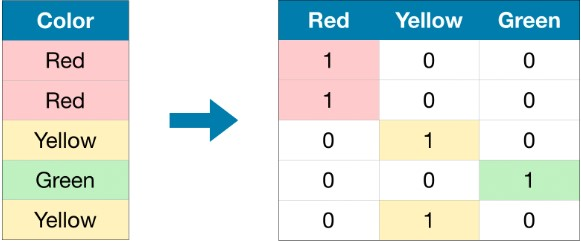

*Figure 5: One-hot encoding on the `Color` categorical variable. Notice that we create a new column for each unique entry, replacing the original column. Where an entry is present in the original column, we assign a $1$ in the corresponding new column.*

In the original dataset, "Color" is a categorical variable with three categories: "Red", "Yellow", and "Green". The corresponding one-hot encoding contains one column for each possible value, and one row for each row in the original dataset. Wherever the original value was "Red", we put a 1 in the "Red" column; if the original value was "Yellow", we put a 1 in the "Yellow" column, and so on.

In contrast to ordinal encoding, one-hot encoding does not assume an ordering of the categories. Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data (e.g., "Red" is neither more nor less than "Yellow"). We refer to categorical variables without an intrinsic ranking as **nominal variables**.

One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., you generally won't use it for variables taking more than 15 different values). This is because one-hot encoding can greatly expand the size of the dataset. Thus, we want to use it on categorical variables of relatively low **cardinality**.

We can see how many new columns we need for a specific categorical variable by seeing how many unique entries it contains:

In [25]:
# How many columns are needed to one-hot encode the 'Neighborhood' variable in the training data?
num_cols_neighborhood = X_train['Neighborhood'].nunique()
print(f'How many columns are needed to one-hot encode the "Neighborhood" variable in the training data? {num_cols_neighborhood}')

How many columns are needed to one-hot encode the "Neighborhood" variable in the training data? 25


We will only only create a one-hot encoding for columns with cardinality less than $10$ (`low_cardinality_cols`). The other columns (`high_cardinality_cols`) will be dropped from the dataset:

In [26]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Neighborhood', 'Exterior1st', 'Exterior2nd']


Let's now perform one-hot encoding on the dataset. We will set the preprocessed DataFrames to `OH_X_train` and `OH_X_valid`, respectively. Note the following parameters:

- We set `handle_unknown='ignore'` to avoid errors when the validation data contains classes that aren't represented in the training data (solves the problem we faced when working with the ordinal encoding example).
- Setting `sparse_output=False` ensures that the encoded columns are returned as a numpy array (instead of a sparse matrix).

In [27]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# make sure column names are all of type str
OH_X_train.columns = OH_X_train.columns.astype('str')
OH_X_valid.columns = OH_X_valid.columns.astype('str')

OH_X_train

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,112,113,114,115,116,117,118,119,120,121
Id,,,,,,,,,,,,,,,,,,,,,
619,20,11694,9,5,2007,2007,48,0,1774,1822,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
871,20,6600,5,5,1962,1962,0,0,894,894,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
93,30,13360,5,7,1921,2006,713,0,163,876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
818,20,13265,8,5,2002,2002,1218,0,350,1568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
303,20,13704,7,5,2001,2002,0,0,1541,1541,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,60,9430,8,5,1999,1999,1163,0,89,1252,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
836,20,9600,4,7,1950,1995,442,0,625,1067,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1217,90,8930,6,5,1978,1978,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Notice once again we only have numeric data, but also notice the new columns we have added for the one-hot encoding. This scores as follows:

In [28]:
print(f'MAE (One-Hot Encoding): {score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)}')

MAE (One-Hot Encoding): 17525.345719178084


In this case, dropping the categorical columns performed worst, since it had the highest MAE score. As for the other two approaches, Ordinal Encoding appeared to perform better over One-Hot encoding, however the difference is still small.

In general, one-hot encoding (Approach 3) will typically perform best, and dropping the categorical columns (Approach 1) typically performs worst, but it varies on a case-by-case basis.

## 4 Pipelines

**Pipelines** are a simple way to keep our data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so we can use the whole bundle as if it were a single step.

Many data scientists hack together models without pipelines, but pipelines have some important benefits. Those include:

1. **Cleaner Code:** Accounting for data at each step of preprocessing can get messy. With a pipeline, we won't need to manually keep track of our training and validation data at each step.
2. **Fewer Bugs:** There are fewer opportunities to misapply a step or forget a preprocessing step.
3. **Easier to Productionize:** It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.
4. **More Options for Model Validation:** We will look at an example in the next section, which covers cross-validation.

Before we get started, we will import our data again. This step has been performed many times now, we keep only numerical and low cardinality categorical data for this example:

*Note: the data at the end of this column contains numerical, categorical, and missing data.*

In [29]:
# Read the data
X_full = pd.read_csv('Assets/iowa_data.csv', index_col='Id')
X_test_full = pd.read_csv('Assets/housingprices_test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(
    X_full, y, 
    train_size=0.8, test_size=0.2,
    random_state=0,
)

# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns 
                    if X_train_full[cname].nunique() < 10 
                    and X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns 
                  if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In this example, we will create a pipeline to:

- Impute the missing data
- One-Hot encode the categorical data
- Create a Random Forest model

Then, we will use it to fit, predict, and evaluate.

### 4.1 Defining preprocessing steps

We will create an imputer for the numerical data, along with a pipeline to combine the imputing and one-hot encoding of the categorical data. To bundle together these preprocessing steps, we use the `ColumnTransformer` class. This will allow us to combine the numerical and categorical transformers into one process:

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                                  'FullBath', 'HalfBath', 'BedroomAbvGr',
                                  'Kit...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Condition1', 'Condition2',
                                  'BldgType', 'HouseStyle', 'RoofStyle',
                                  'RoofMatl', 'MasVnrType', 'ExterQual',
                                  'ExterCond', 'Foundation', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'Functional', 'FireplaceQu', ...])])

Notice that we get a very handy tree as the output. This let's us easily see the process we created!

### 4.2 Define the model

We will define a Random Forest model as we have before:

In [31]:
model = RandomForestRegressor(n_estimators=220, random_state=0)
model

RandomForestRegressor(n_estimators=220, random_state=0)

By outputting the model, we can easily see some details about it.

### 4.3 Create and evaluate the pipeline

Finally, we use the `Pipeline` class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:

- With the pipeline, we preprocess the training data and fit the model in a single line of code.
- With the pipeline, we supply the unprocessed features in X_valid to the predict() command, and **the pipeline automatically preprocesses the features before generating predictions**. (However, without a pipeline, we have to remember to preprocess the validation data before making predictions.)

In [32]:
# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model),
])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 17344.229732254047


We can now generate new test predictions to submit:

In [33]:
# Preprocessing of test data, fit model
preds_test = pipeline.predict(X_test)

# create output dataframe
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})

# uncomment below line to save to file
#output.to_csv('submission_IntermediateML.csv', index=False)

output

,Id,SalePrice
0,1461,127849.809091
1,1462,154109.772727
2,1463,185781.800000
3,1464,184875.963636
4,1465,199641.968182
...,...,...
1454,2915,87205.454545
1455,2916,86798.913636
1456,2917,149784.945455
1457,2918,110070.640909


When submitted, this obtained a score of $16430.83788$, quite an improvement!

## 5 Cross-Validation

So far, we have measured model quality with a validation (holdout) set, but there are some drawbacks to this approach. To see this, imagine you have a dataset with $5000$ rows. You will typically keep about $20\%$ of the data as a validation dataset, or $1000$ rows. But this leaves some random chance in determining model scores. That is, a model might do well on one set of $1000$ rows, even if it would be inaccurate on a different $1000$ rows.

In general, the larger the validation set, the less noise (randomness) there is in our measure of model quality, and the more reliable it will be. Unfortunately, we can only get a large validation set by removing rows from our training data, and smaller training datasets mean worse models!

In **cross-validation**, we run our modeling process on different subsets of the data to get multiple measures of model quality. For example, we could begin by dividing the data into $5$ pieces, each $20\%$ of the full dataset. In this case, we say that we have broken the data into $5$ *folds*. Then, we run one experiment for each fold:

- In Experiment 1, we use the first fold as a validation set and everything else as training data. This gives us a measure of model quality based on a $20\%$ holdout set.
- In Experiment 2, we hold out data from the second fold (and use everything except the second fold for training the model). The holdout set is then used to get a second estimate of model quality.
- We repeat this process, using every fold once as the holdout set. Putting this together, $100\%$ of the data is used as holdout at some point, and we end up with a measure of model quality that is based on all of the rows in the dataset (even if we don't use all rows simultaneously).

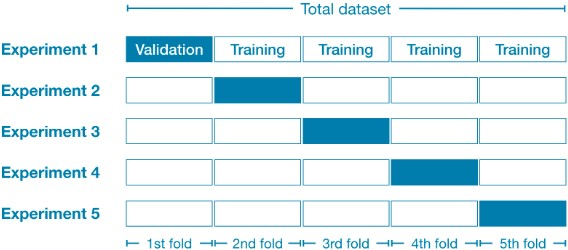

*Figure 6: Splitting the total dataset into $5$ folds. We then perform $5$ experiments, where we change which subset we use as the validation data in each experiment.*

Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

So, given these tradeoffs, when should you use each approach?

- For *small* datasets, where extra computational burden isn't a big deal, you *should* run cross-validation.
- For *larger* datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

If your model takes a couple minutes or less to run, it's probably worth switching to cross-validation.

As is their purpose, pipelines make this process a lot easier. We must first properly present our full training data:

In [34]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns 
                    if X_full[cname].nunique() < 10 
                    and X_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_full.columns 
                  if X_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

We will then use the pipeline we created in the previous section. We obtain the cross-validation scores with the `cross_val_score()` function from `sklearn.model_selection`. We set the number of folds with the `cv` parameter:

In [35]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(
    pipeline, 
    X_train, y,
    cv=5,
    scoring='neg_mean_absolute_error'
)

print(f'MAE scores: {scores}')

MAE scores: [17670.61953611 17490.87171544 17768.41489726 16074.80569738
 19122.8505137 ]


It is a little surprising that we specify *negative* MAE. Scikit-learn has a convention where all metrics are defined so a high number is better. Using negatives here allows them to be consistent with that convention, though negative MAE is almost unheard of elsewhere.

We typically want a single measure of model quality to compare alternative models. So we take the average across experiments:

In [36]:
print("Average MAE score:", scores.mean())

Average MAE score: 17625.512471980073


### 5.1 Parameter optimization

We can use cross-validation to try and find optimal parameters for our model. We saw how to do this previously, by running through various parameter settings until we find a minimum between underfitting and overfitting. To aid in this, we will create a function to get the cross-validation scores of a random forest model, where we input the `n_estimators` we want to use:

In [37]:
def get_score(n_estimators):
    '''
    Return the average MAE over 5 CV folds of a random forest model.
    
    Inputs: 
        n_estimators: the number of trees in the forest
    '''
    
    # create pipeline to perform the preprocessing defined in section 4
    # and to then use a Random forest model of the specified parameter
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0)),
    ])
    
    # get scores using cross validation
    scores = -1 * cross_val_score(
        pipeline, 
        X_train, y,
        cv=5,
        scoring='neg_mean_absolute_error'
   )
    
    return scores.mean()

Using this function, we can loop over many values of `n_estimators` in order to see what the optimal value may be:

Text(0.5, 1.0, 'Using cross-validation to find optimal parameter values')

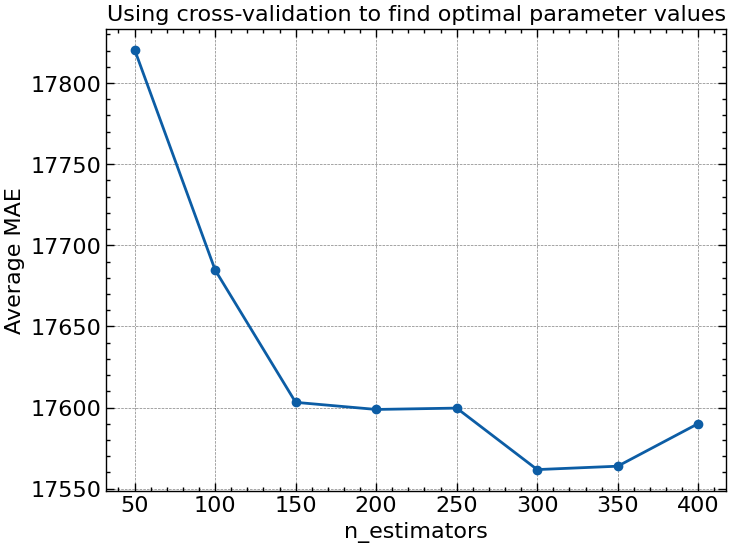

In [38]:
# loops from n_estimators=50 to 450 in steps of 50 and returns the score
# saves the keys as the value of n_estimators used, while value is the scores
results = {n: get_score(n) for n in range(50, 450, 50)}

plt.plot(
    list(results.keys()), 
    list(results.values()),
    'o-'
)
plt.xlabel('n_estimators')
plt.ylabel('Average MAE')
plt.title('Using cross-validation to find optimal parameter values')

Notice we see the underfitting and overfitting curves, as well as the minimum between them. We find from this that the optimal value for `n_estimators` is $\approx 300$.

It may be useful to learn more about [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization), it is encouraged to start with grid search, which is a straightforward method for determining the best combination of parameters for a machine learning model. Thankfully, scikit-learn also contains a built-in function `GridSearchCV()` that can make the grid search code very efficient.

> In machine learning, hyperparameter optimization (or tuning) is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

## 6 XGBoost

In this section, we will learn how to build and optimize models with **gradient boosting**. This method dominates many Kaggle competitions and achieves state-of-the-art results on a variety of datasets.

So far, we have mostly made predictions with the random forest method, which achieves better performance than a single decision tree simply by averaging the predictions of many decision trees. We refer to the random forest method as an "ensemble method". By definition, ensemble methods combine the predictions of several models (e.g., several trees, in the case of random forests).

Gradient boosting is another ensemble method that we can use. It is a method that goes through cycles to iteratively add models into an ensemble. It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.) Then, we start the cycle:

- First, we **use the current ensemble to generate predictions** for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
- These predictions are used to **calculate a loss function** (for example, mean squared error).
- Then, we use the loss function to **fit a new model that will be added to the ensemble**. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
- Finally, we **add the new model to ensemble**, and **repeat**.

*Note: The "gradient" in "gradient boosting" refers to the fact that we'll use [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) on the loss function to determine the parameters in this new model.*

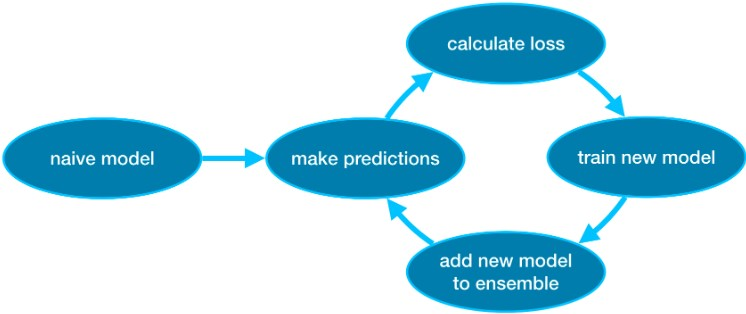

*Figure 7: The gradient boosting ensemble cycle. Starting with a naive model, the loss calculated on current predictions is used to train and add a new model to the ensemble.*

### 6.1 Basic Implementation

In this example, we will work with the ``XGBoost`` library. XGBoost stands for *extreme gradient boosting*, which is an implementation of gradient boosting with several additional features focused on performance and speed. (Scikit-learn has another version of gradient boosting, but XGBoost has some technical advantages.)

We create the data as before. Notice that we are instead using pandas to quickly perform the one-hot encoding, as `pd.get_dummies()` converts categorical variables into dummy/indicator variables:

In [39]:
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)

# Align dataframes by their columns to make sure they are of same form
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In the next code cell, we import the scikit-learn API for XGBoost ([``xgboost.XGBRegressor``](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)). This allows us to build and fit a model just as we would in scikit-learn. As we will see in the output, the ``XGBRegressor`` class has many tunable parameters:

*Note: you will need to `pip install xgboost`, the version used in this notebook was `1.7.2`.*

In [40]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

We can very easily get predictions and the MAE score:

In [41]:
# Get predictions
predictions = model.predict(X_valid)

# Calculate MAE
mae = mean_absolute_error(y_valid, predictions)
print(f'MAE: {mae}')

MAE: 17179.522768621577


### 6.2 Parameter tuning

XGBoost has a few parameters that can dramatically affect accuracy and training speed. Let's dicsuss some of them:

- `n_estimators` specifies how many times to go through the cycle described above. It is equal to the number of models that we include in the ensemble. 
  - Typical value depends a lot on `learning_rate`, discussed later.

- ``early_stopping_rounds`` offers a way to automatically find the ideal value for ``n_estimators``. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for ``n_estimators``. 
  - It's smart to set a high value for ``n_estimators`` and then use ``early_stopping_rounds`` to find the optimal time to stop iterating.
  - Since random chance sometimes causes a single round where validation scores don't improve, we need to specify a number for how many rounds of straight deterioration to allow before stopping. Setting ``early_stopping_rounds=5`` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.
  - When using ``early_stopping_rounds``, we also need to set aside some data for calculating the validation scores - this is done by setting the ``eval_set`` parameter in the `fit` method.
    - Then, if we later want to fit a model with all of our data, we set ``n_estimators`` to whatever value we found to be optimal when run with early stopping.

- `learning_rate` is multiplied by the predictions from each component model before adding them together. This means each tree we add to the ensemble helps us less. 
  - So, we can set a higher value for ``n_estimators`` without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.
  - In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets ``learning_rate=0.1``.

- `n_jobs` allows us to use parallelism to build our models faster. 
  - It's common to set the parameter ``n_jobs`` equal to the number of cores on your machine. On smaller datasets, this won't help much.
  - The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the ``fit`` command.

Now that we have discussed some of the most important parameters for XGBoost, let's incorporate them into our model:

In [42]:
# Define the model
model = XGBRegressor(
    random_state=0,
    n_estimators=500,
    learning_rate=0.05,
    n_jobs=4,
    early_stopping_rounds=5,
)

# Fit the model
# verbose affects the debug output as the model is being fitted
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False,
)

# Get predictions
predictions = model.predict(X_valid)

# Calculate MAE
mae = mean_absolute_error(y_valid, predictions) # Your code here
print(f'MAE: {mae}')

MAE: 16824.68509203767


## 7 Data Leakage

**Data leakage** happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production. In other words, leakage causes a model to look accurate until you start making decisions with the model, and then the model becomes very inaccurate.

There are two main types of leakage: **target leakage** and **train-test contamination**.

### 7.1 Target leakage

**Target leakage** occurs when the predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or **chronological order that data becomes available**, not merely whether a feature helps make good predictions.

Imagine we want to predict who will get sick with pneumonia. The top few rows of our raw data look like this:
 
| **got_pneumonia** | **age** | **weight** | **male** | **took_antibiotic_medicine** | **...** |
|:-----------------:|:-------:|:----------:|:--------:|:----------------------------:|:-------:|
|       False       |    65   |     100    |   False  |             False            |   ...   |
|       False       |    72   |     130    |   True   |             False            |   ...   |
|        True       |    58   |     100    |   False  |             True             |   ...   |

The raw data shows a strong relationship between the people who got pneumonia and those who took antibiotic medicine. Thus, our model may predict that if you were to take antibiotic medicine, you are likely to get pneumonia. However, we know that people take antibiotic medicines *after* getting pneumonia in order to recover, so ``took_antibiotic_medicine`` is frequently changed *after* the value for ``got_pneumonia`` is determined, explaining the correlation. This is target leakage.

To prevent this type of data leakage, any variable updated (or created) after the target value is realized should be excluded.

### 7.2 Train-test contamination

**Train-test contamination** occurs when we aren't careful to distinguish training data from validation data. Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. This process can be corrupted in subtle ways if the validation data affects the preprocessing behavior.

For example, imagine we run preprocessing (like fitting an imputer for missing values) before calling ``train_test_split()``. The end result? Our model may get good validation scores, giving us great confidence in it, but perform poorly when we deploy it to make decisions.

After all, we incorporated data from the validation or test data into how we make predictions, so the may do well on that particular data even if it can't generalize to new data. This problem becomes even more subtle (and more dangerous) when we do more complex feature engineering.

If the validation is based on a simple train-test split, exclude the validation data from any type of fitting, including the fitting of preprocessing steps.

### 7.3 Example scenarios

**Scenario 1:**

Nike has hired you as a data science consultant to help them save money on shoe materials. Your first assignment is to review a model one of their employees built to predict how many shoelaces they'll need each month. The features going into the machine learning model include:

- The current month (January, February, etc)
- Advertising expenditures in the previous month
- Various macroeconomic features (like the unemployment rate) as of the beginning of the current month
- The amount of leather they ended up using in the current month

The results show the model is almost perfectly accurate if you include the feature about how much leather they used. But it is only moderately accurate if you leave that feature out. You realize this is because the amount of leather they use is a perfect indicator of how many shoes they produce, which in turn tells you how many shoelaces they need.

Do you think the leather used feature constitutes a source of data leakage? If your answer is "it depends," what does it depend on?

> This is tricky, and it depends on details of how data is collected (which is common when thinking about leakage). Would you at the beginning of the month decide how much leather will be used that month? If so, this is ok. But if that is determined during the month, you would not have access to it when you make the prediction. If you have a guess at the beginning of the month, and it is subsequently changed during the month, the actual amount used during the month cannot be used as a feature (because it causes leakage).

You have a new idea. You could use the amount of leather Nike ordered (rather than the amount they actually used) leading up to a given month as a predictor in your shoelace model.

Does this change your answer about whether there is a leakage problem? If you answer "it depends," what does it depend on?

> This could be fine, but it depends on whether they order shoelaces first or leather first. If they order shoelaces first, you won't know how much leather they've ordered when you predict their shoelace needs. If they order leather first, then you'll have that number available when you place your shoelace order, and you should be ok.

**Scenario 2:**

Your friend, who is also a data scientist, says he has built a model that will let you turn your bonus into millions of dollars. Specifically, his model predicts the price of a new cryptocurrency (like Bitcoin, but a newer one) one day ahead of the moment of prediction. His plan is to purchase the cryptocurrency whenever the model says the price of the currency (in dollars) is about to go up.

The most important features in his model are:

- Current price of the currency
- Amount of the currency sold in the last $24$ hours
- Change in the currency price in the last $24$ hours
- Change in the currency price in the last $1$ hour
- Number of new tweets in the last $24$ hours that mention the currency

The value of the cryptocurrency in dollars has fluctuated up and down by over $100$ dollars in the last year, and yet his model's average error is less than $1$ dollars. He says this is proof his model is accurate, and you should invest with him, buying the currency whenever the model says it is about to go up.

Is he right? If there is a problem with his model, what is it?

> There is no source of leakage here. These features should be available at the moment you want to make a predition, and they're unlikely to be changed in the training data after the prediction target is determined. But, the way he describes accuracy could be misleading if you aren't careful. If the price moves gradually, today's price will be an accurate predictor of tomorrow's price, but it may not tell you whether it's a good time to invest. For instance, if it is $100$ dollars today, a model predicting a price of $100$ dollars tomorrow may seem accurate, even if it can't tell you whether the price is going up or down from the current price. A better prediction target would be the change in price over the next day. If you can consistently predict whether the price is about to go up or down (and by how much), you may have a winning investment opportunity.

**Scenario 3:**

An agency that provides healthcare wants to predict which patients from a rare surgery are at risk of infection, so it can alert the nurses to be especially careful when following up with those patients.

You want to build a model. Each row in the modeling dataset will be a single patient who received the surgery, and the prediction target will be whether they got an infection.

Some surgeons may do the procedure in a manner that raises or lowers the risk of infection. But how can you best incorporate the surgeon information into the model?

You have a clever idea.

1. Take all surgeries by each surgeon and calculate the infection rate among those surgeons.
2. For each patient in the data, find out who the surgeon was and plug in that surgeon's average infection rate as a feature.

Does this pose any target leakage issues? Does it pose any train-test contamination issues?

> This poses a risk of both target leakage and train-test contamination (though you may be able to avoid both if you are careful).
> 
> You have target leakage if a given patient's outcome contributes to the infection rate for his surgeon, which is then plugged back into the prediction model for whether that patient becomes infected. You can avoid target leakage if you calculate the surgeon's infection rate by using only the surgeries before the patient we are predicting for. Calculating this for each surgery in your training data may be a little tricky.
> 
> You also have a train-test contamination problem if you calculate this using all surgeries a surgeon performed, including those from the test-set. The result would be that your model could look very accurate on the test set, even if it wouldn't generalize well to new patients after the model is deployed. This would happen because the surgeon-risk feature accounts for data in the test set. Test sets exist to estimate how the model will do when seeing new data. So this contamination defeats the purpose of the test set.

**Scenario 4:**

You will build a model to predict housing prices. The model will be deployed on an ongoing basis, to predict the price of a new house when a description is added to a website. Here are four features that could be used as predictors.

1. Size of the house (in square meters)
2. Average sales price of homes in the same neighborhood
3. Latitude and longitude of the house
4. Whether the house has a basement

You have historic data to train and validate the model.

Which of the features is most likely to be a source of leakage?

> 2 is the source of target leakage. Here is an analysis for each feature:
> 
> 1. The size of a house is unlikely to be changed after it is sold (though technically it's possible). But typically this will be available when we need to make a prediction, and the data won't be modified after the home is sold. So it is pretty safe.
> 
> 2. We don't know the rules for when this is updated. If the field is updated in the raw data after a home was sold, and the home's sale is used to calculate the average, this constitutes a case of target leakage. At an extreme, if only one home is sold in the neighborhood, and it is the home we are trying to predict, then the average will be exactly equal to the value we are trying to predict. In general, for neighborhoods with few sales, the model will perform very well on the training data. But when you apply the model, the home you are predicting won't have been sold yet, so this feature won't work the same as it did in the training data.
> 
> 3. These don't change, and will be available at the time we want to make a prediction. So there's no risk of target leakage here.
>
> 4. This also doesn't change, and it is available at the time we want to make a prediction. So there's no risk of target leakage here.